In [2]:
%pip install qiskit ipywidgets
%pip install matplotlib
%pip install qiskit-ibm-runtime
%pip install pylatexenc
%pip install qiskit-ionq


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fouad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fouad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 5.1/5.1 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.24.1
    Uninstalling qiskit-terra-0.24.1:
      Successfully uninstalled qiskit-terra-0.24.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\fouad\\AppData\\Local\\Temp\\pip-uninstall-phvsiuof\\_accelerate.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\Users\fouad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fouad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fouad\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble, Aer
from qiskit.circuit.library import NLocal
from qiskit.primitives import Sampler as SamplerPRIM
from qiskit_aer import AerProvider

f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")

#IBM Backend
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler as SamplerIBM, Session, Options, Estimator
next = f.readline()
# Put your own token here if you would like to run it
TOKEN_IBM = next[:len(next)-1]
service_ibm = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN_IBM)
backend_ibm = service_ibm.backend("ibmq_qasm_simulator")

#AER Backend and Noise
from qiskit_aer.backends import AerSimulator
from qiskit_aer.noise import NoiseModel

backend_aer = Aer.get_backend('aer_simulator')

#IonQ Backend
from qiskit_ionq import IonQProvider, ErrorMitigation

next = f.readline()
# Put your own token here if you would like to run it
TOKEN_IONQ = next[:len(next)-1]
service_ionq = IonQProvider(TOKEN_IONQ)
backend_ionq = service_ionq.get_backend("ionq_simulator")

f.close()

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
%pip show qiskit-ionq
%pip show qiskit

In [ ]:
# Building the testing circuit
BITS = 4
SHOTS = 1000
qreg = QuantumRegister(BITS)
creg = ClassicalRegister(BITS)
qc = QuantumCircuit(qreg, creg)

for i in range(BITS):
    qc.h(i)
    qc.measure(i,i)

display(qc.draw("mpl"))

In [ ]:
# Using Sampler offerred by IBM
sampler = SamplerIBM(backend_ibm)
job = sampler.run(qc, shots=SHOTS)
result = job.result().quasi_dists[0]
plt.bar(result.keys(), result.values())
plt.title("IBM Sampler, with " + str(SHOTS) + " shots. Average: " + str(sum(result.values())/len(result.values())))
plt.show()

# Using default Sampler primitive
sampler = SamplerPRIM()
job = sampler.run(qc,shots=SHOTS)
result = job.result().quasi_dists[0]
plt.bar(result.keys(),result.values())
plt.title("Default Sampler, with " + str(SHOTS) + " shots. Average: " + str(sum(result.values())/len(result.values())))
plt.show()

# This is to compare the difference between the IonQ Sampler, which samples using real probabilities, and the default sampler, 

In [ ]:
# Testing IonQ Backend. Does not have error mitigation (options are unused)

job = backend_ionq.run(qc)
counts = job.result().get_counts()
plt.bar(counts.keys(), counts.values())
plt.title("IonQ Simulator, without Error Mitigation. Average: " + str(sum(counts.values())/len(counts.values())))
plt.show()


In [ ]:
from qiskit import QuantumCircuit
from qiskit_ionq import ErrorMitigation
from functools import reduce

# Create a basic Bell State circuit:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

display(qc.draw("mpl"))

EM_0 = []
EM_1 = []
EM_S_0 = []
EM_S_1 = []
NO_0 = []
NO_1 = []

print(backend_ionq.run(qc).result().get_probabilities())

for i in range(10):
    # Run the circuit on IonQ's platform with error mitigation:
    job = backend_ionq.run(qc, error_mitigation=ErrorMitigation.DEBIASING)

    # Print the results.
    EM_0 += [job.result().get_counts().get('00')/1000]
    EM_1 += [job.result().get_counts().get('11')/1000]

    # Get results with a different aggregation method when debiasing
    # is applied as an error mitigation strategy
    EM_S_0 += [job.result(sharpen=True).get_counts().get('00')/1000]
    EM_S_1 += [job.result(sharpen=True).get_counts().get('11')/1000]

    job = backend_ionq.run(qc, error_mitigation=ErrorMitigation.NO_DEBIASING)

    NO_0 += [job.result().get_counts().get('00')/1000]
    NO_1 += [job.result().get_counts().get('11')/1000]

    print(i)

EM_sum = {'00': sum(EM_0)/10, '11': sum(EM_1)/10}
EM_S_sum = {'00': sum(EM_S_0)/10, '11': sum(EM_S_1)/10}
NO_sum = {'00': sum(NO_0)/10, '11': sum(NO_1)/10}

print(EM_sum)
print(EM_S_sum)
print(NO_sum)


In [ ]:
%pip install numpy

import matplotlib.pyplot as plt
import numpy as np

n = len(NO_sum.values())
ind = np.arange(n)
width = 0.1

no_bar = NO_sum.values()
bar1 = plt.bar(ind, no_bar, width, label="Noisy")

em_bar = EM_sum.values()
bar2 = plt.bar(ind+width, em_bar, width, label="Debaising")

em_s_bar = EM_S_sum.values()
bar3 = plt.bar(ind+width*2, em_s_bar, width, label="Debaising and Sharpening")

plt.axhline(y = .5, color = 'r', label="Theory")


plt.legend()
plt.xlabel("Values")
plt.ylabel("Counts")
plt.title("Results of Job")
plt.ylim(.475, .525)

plt.xticks(ind+width, NO_sum.keys())
plt.show()


In [ ]:
#Testing IBM Sampler, with default resilience level of 1, which uses M3 error mitigation

options_ibm = Options()
options_ibm.resilience_level = 1
with Session(service=service_ibm, backend="ibmq_qasm_simulator") as session:
    sampler = SamplerIBM(session=session, options=options_ibm)

job = sampler.run(qc)
result = job.result()
plt.bar(counts.keys(), counts.values())
plt.title("IBM Sampler, with M3 Mitigation. Average: " + str(sum(counts.values())/len(counts.values())))
plt.show()

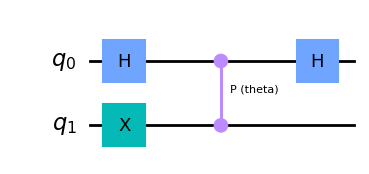

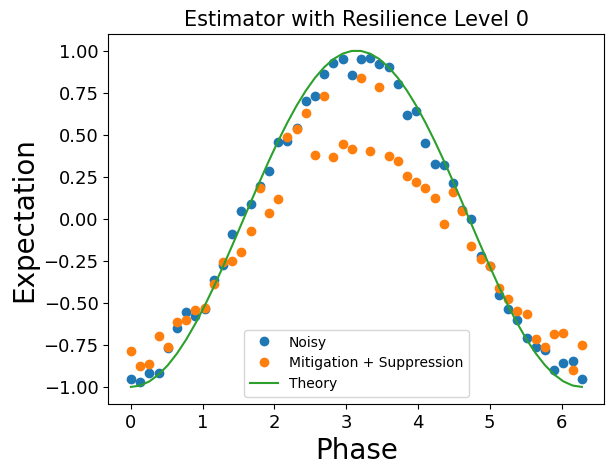

In [6]:
#Testing different resilience levels for the Estimator of QiskitRuntimeService

from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

display(qc.draw("mpl"))

## Setup phases
import numpy as np

phases = np.linspace(0, 2 * np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [ [phase] for phase in phases]
## Create noise model
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import Options


# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42,
}

from qiskit_ibm_runtime import Session, QiskitRuntimeService, Estimator

# Add your token below
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN_IBM)

noisy_exp_values = []
exp_values_with_em_es = []

r_level = 0

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    # generate noisy results
    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    noisy_exp_values = result.values

    options.optimization_level = 2
    options.resilience_level = r_level

    # leverage mitigation and suppression
    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    exp_values_with_em_es = result.values

    session.close()



import matplotlib.pyplot as plt
plt.plot(phases, noisy_exp_values, "o", label="Noisy")
plt.plot(phases, exp_values_with_em_es, "o", label="Mitigation + Suppression")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="Theory")
plt.xlabel("Phase", fontsize=20)
plt.ylabel("Expectation", fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("Estimator with Resilience Level " + str(r_level), fontsize=15)
plt.legend()
plt.show()

In [ ]:
#Testing different resilience levels for the Estimator of QiskitRuntimeService

from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

qc.draw("mpl")

## Setup phases
import numpy as np

phases = np.linspace(0, 2 * np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [ [phase] for phase in phases]
## Create noise model
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import Options


# Make a noise model
fake_backend = Aer.get_backend('aer_simulator')
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42,
}


from qiskit_ibm_runtime import Session, QiskitRuntimeService, Estimator

# Add your token below
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN_IBM)

noisy_exp_values = []
exp_values_with_em_es = []

r_level = 1

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    # generate noisy results
    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    noisy_exp_values = result.values

    options.optimization_level = 2
    options.resilience_level = r_level

    # leverage mitigation and suppression
    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    exp_values_with_em_es = result.values

    session.close()



import matplotlib.pyplot as plt
plt.plot(phases, noisy_exp_values, "o", label="Noisy")
plt.plot(phases, exp_values_with_em_es, "o", label="Mitigation + Suppression")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="Theory")
plt.xlabel("Phase")
plt.ylabel("Expectation")
plt.title("Estimator with Resilience Level " + str(r_level))
plt.legend()
plt.show()

In [ ]:
circ = QuantumCircuit(2)
circ.cry(1, 0, 1)
display(circ.decompose().draw())

circ = QuantumCircuit(2)
circ.cz(0,1)
display(circ.decompose().draw())

circ = QuantumCircuit(3)
circ.ccx(0,1,2)
display(circ.decompose().decompose().decompose().decompose().draw())

circ = QuantumCircuit(2)
circ.ch(0,1)
display(circ.decompose().decompose().decompose().decompose().draw())

# how to do complex conjugate of a matrix (to reconstruct the Tdg matrix)?
# if not, need to transform general single-qubit unitary U(phi, theta, lambda) into IonQ native gates.